In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [41]:
#Make a class for the diode interpolation...
class InterDiode:
    
    def __init__(self, name = "Lakeshore DT-670", data_file = "lakeshore.txt"): # Default use lakshore model, data...
        self.data_loaded = False
        self.name = name
        self.load_data(data_file) #Needs data in 3 column text file with columns T, V, dV/dT
    

    def load_data(self, data_file):
        self.data = np.loadtxt(data_file) #Columns are T, V, dV/dT

        self.data = self.data[self.data[:,1].argsort()] #Sorting by voltage, column 1 so that splrep works properly

        self.temp = self.data[:,0]
        self.volt = self.data[:, 1]
        self.dvdt = self.data[:, 2]
        self.data_loaded = True
        
        #Get the spline object (cubic)
        self.spln = interpolate.splrep(self.volt, self.temp, k=3)
        
    def interpolateDiode(self,interx): #Evaluate the spline
        #if within data range, all is good.
        if(self.data_loaded) and (interx > self.data[:, 1][0] and interx < self.data[:, 1][-1]): 
            return interpolate.splev(interx, self.spln)
        #If we are extrapolating, print a warning.
        elif (self.data_loaded):
            print("Beware, extrapolating!") 
            return interpolate.splev(interx, self.spln)
        #If the data isn't loaded, load it and go on...
        else:
            print("Loading data...")
            self.load_data(self.data_file)
            return interpolate.splev(interx, self.spln)


In [44]:
#Example of how to use the class...

#Initiate an instance of the default class (Lakeshore DT 670)
dt670 = InterDiode()

#Interpolate what temperature would give a voltage of 0.19 at 10 uA current. 
print("Interpolated temperature for voltage of 0.19V at 10 uA: %.3f Kevlin"%dt670.interpolateDiode(0.19))

Interpolated temperature for voltage of 0.19V at 10 uA: 457.002 Kevlin


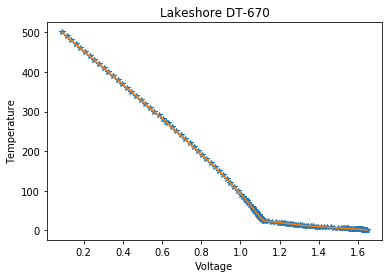

In [45]:
#Checking interpolation across full range
interx = np.linspace(dt670.volt[0], dt670.volt[-1], 1000)
intery = interpolate.splev(interx, dt670.spln)

plt.plot(dt670.volt, dt670.temp, '*')
plt.plot(interx, intery, '-')
plt.xlabel('Voltage')
plt.ylabel('Temperature')
plt.title(dt670.name)

Looking good! Now let's try to estimate the error...

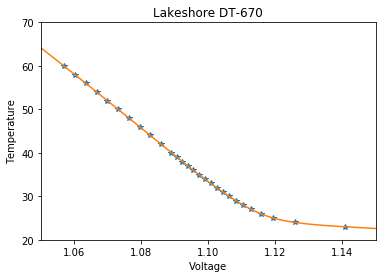

In [46]:
#A quick zoom in...
plt.plot(dt670.volt, dt670.temp, '*')
plt.plot(interx, intery, '-')
plt.xlabel('Voltage')
plt.ylabel('Temperature')
plt.xlim(1.05, 1.15)
plt.ylim(20, 70)
plt.title(dt670.name)

Okay so the function looks continuous... And we know it is piecewise continuous. It also doesn't have poles so we shouldn't expect ringing. 

Since we know we forced the polynomial order to be 3 (cubic spline) an upper bound on the maximum error can be calculated using the fourth power of the ditance between data points. In the spline case, we will use the largest distance between the knots (to the fourth power) as a metric on our error and multiply this by the constant : $$max(\frac{f(x)}{4!})$$ as shown in [1]. 

For references see: 

[1] https://www.math.uh.edu/~jingqiu/math4364/spline.pdf p.12

[2] Press, William H., et al. Numerical recipes 3rd edition: The art of scientific computing. Cambridge university press, 2007, pp120-123.

In [105]:
knots = dt670.spln[0] #The knots in the spline.

#Searching for maximum distance between the knots. 
maxd=max(np.diff(knots)) #Variable for maximum distance between knots

        
#We can get the third derivative at all the data points we need. Then we just need to compute one more numerically.
vspace = np.linspace(min(dt670.volt), max(dt670.volt), 10) #voltage interpolation space
third_der = interpolate.splev(vspace, dt670.spln, der=3)

#Note: dx is constant and set at:
dx=(max(dt670.volt) - min(dt670.volt))/len(third_der)

#rough approximation of the fourth derivative of the spline
fourth_der_approx = np.diff(third_der)/dx 

#The constant we need to multiply by the 
const = (max(fourth_der_approx)/np.math.factorial(4))

        
print(r"Error bound: plus or minus %.2f Kelvin"%(np.abs(const*maxd**4.0)))

Error bound: plus or minus 0.60 Kelvin


And so I would say our error is ~ $1$ Kelvin due to the error in our fourth derivative estimate. 

Another way of doing this would be to fit the data to a function, calculate the fourth derivative analytically and then take the maximum of that to reduce the error further. 